<a href="https://colab.research.google.com/github/Steved0/TF_Image_Classifier/blob/master/Homework_Week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import sklearn
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD




In [248]:
df_yr = pdr.data.get_data_yahoo('acn',start='2017-09-01',end = '2019-09-01')
df_yr.to_csv('ACN.csv', index=False)
df_yr.head()


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-09-01,130.949997,129.869995,130.949997,130.100006,1528300.0,125.528412
2017-09-05,130.389999,129.100006,130.100006,129.770004,2442400.0,125.210014
2017-09-06,131.380005,130.050003,130.210007,131.119995,1549900.0,126.512550
2017-09-07,134.830002,131.360001,131.500000,134.240005,2094800.0,129.522934
2017-09-08,134.970001,133.649994,134.410004,133.720001,2178800.0,129.021210


In [249]:
df_yr.describe()

,High,Low,Open,Close,Volume,Adj Close
count,502.000000,502.000000,502.000000,502.000000,5.020000e+02,502.000000
mean,163.094203,160.696773,161.878725,161.974682,2.092799e+06,159.694808
std,15.347445,15.315443,15.335729,15.350104,8.626701e+05,16.488716
min,130.389999,129.100006,130.100006,129.770004,6.018000e+05,125.210014
25%,153.462505,150.677502,152.289993,152.110004,1.587400e+06,149.312290
50%,161.519997,159.375000,160.349998,160.435005,1.924750e+06,157.369926
75%,171.547501,169.394997,170.252499,170.312504,2.317550e+06,167.383572
max,200.679993,197.440002,200.000000,198.740005,8.561500e+06,198.740005


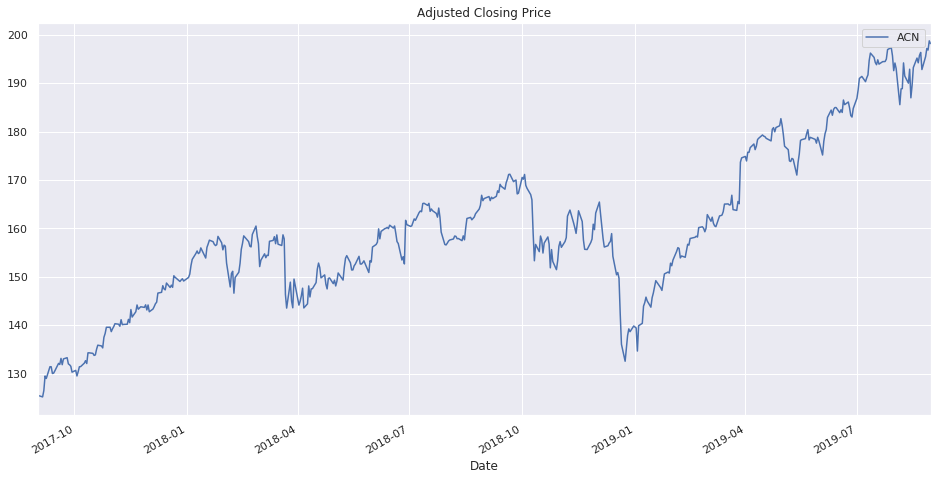

In [259]:


features = ['Open', 'High', 'Low', 'Close', 'Volume']
X = df_yr[features]
#print(X.head())

df_yr['Adj Close'].plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', legend ='Adj Close', grid=True)



In [0]:
window_size = 28
num_samples = len(df_yr) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)


In [0]:
data = df_yr['Adj Close'].values[indices]

In [0]:
X = data[:,:-1]
y = data[:,-1]


In [0]:
split_fraction = .8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

**Approach #1**

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

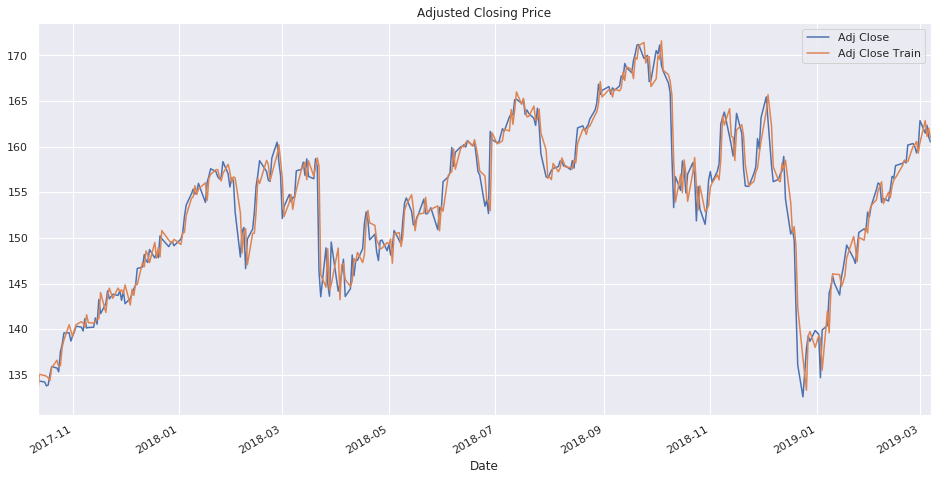

In [265]:
# Training data
df_ridge = df_yr.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)


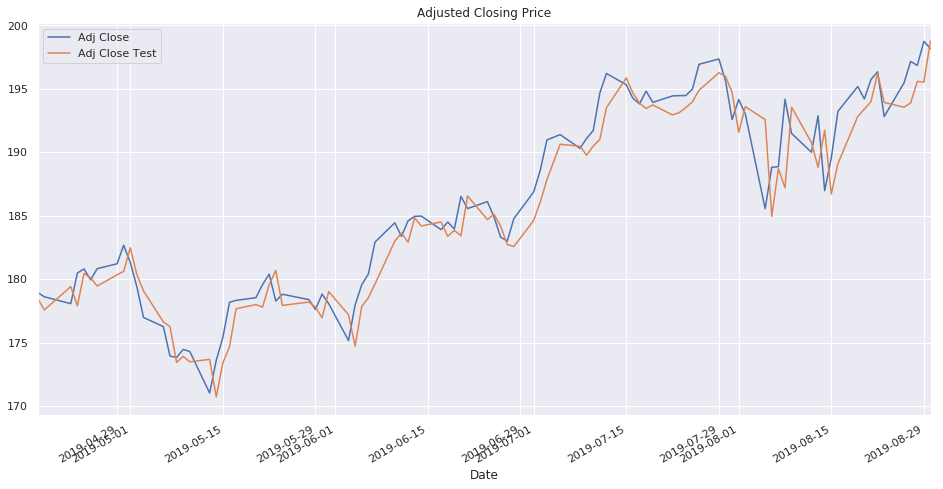

In [266]:
# Test data
df_ridge = df_yr.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] 
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)


**Approach #2**

In [0]:
# Train
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

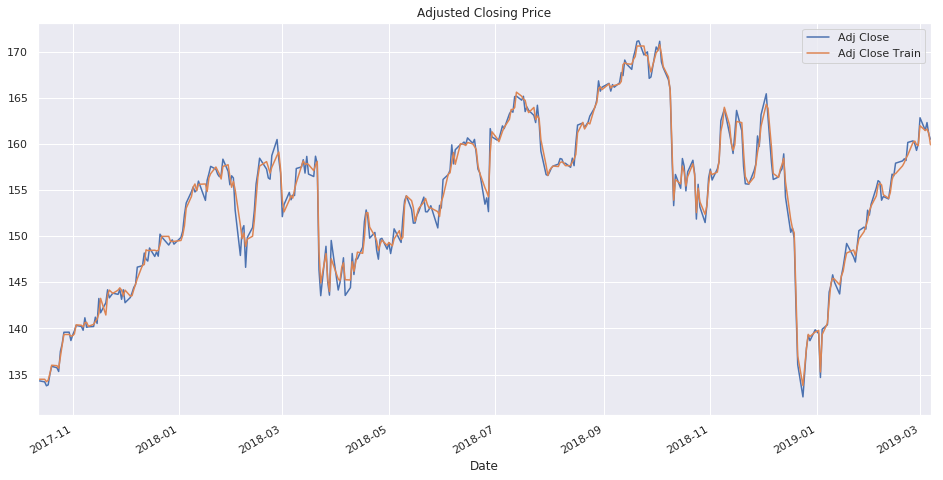

In [269]:
# Training data
df_gb = df_yr.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 28 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)


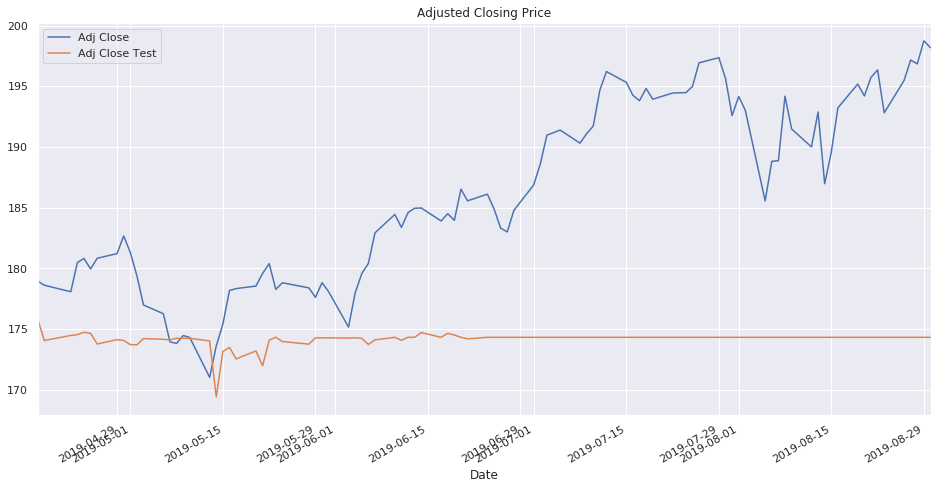

In [270]:
# Test data
df_gb = df_yr.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] 
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)


**Approach #3**

In [0]:
#Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"), 
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

In [272]:
keras_model.summary()


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_19 (Conv1D)           (None, 28, 128)           768       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 28, 128)           82048     
_________________________________________________________________
lstm_19 (LSTM)               (None, 28, 128)           131584    
_________________________________________________________________
lstm_20 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_30 (Dense)             (None, 1)               

In [0]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.8)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df_yr['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]


In [283]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))

Train on 379 samples, validate on 95 samples
Epoch 1/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.2120 - val_loss: 0.2456 - val_mean_absolute_error: 0.6739
Epoch 2/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.2120 - val_loss: 0.2456 - val_mean_absolute_error: 0.6739
Epoch 3/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.2120 - val_loss: 0.2456 - val_mean_absolute_error: 0.6739
Epoch 4/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.2120 - val_loss: 0.2456 - val_mean_absolute_error: 0.6739
Epoch 5/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.2120 - val_loss: 0.2456 - val_mean_absolute_error: 0.6739
Epoch 6/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.2120 - val_loss: 0.2456

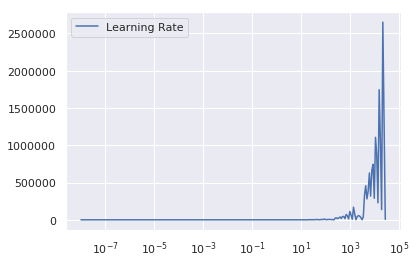

In [284]:
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])


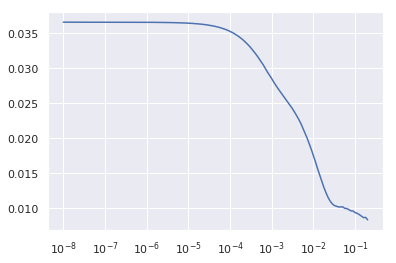

In [288]:
plt.semilogx(history.history['lr'][:147], history.history['loss'][:147])


In [289]:

# Observing the above graph, 0.1 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.1, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))



Train on 379 samples, validate on 95 samples
Epoch 1/250
379/379 [==============================] - 8s 22ms/step - loss: 0.0412 - mean_absolute_error: 0.2289 - val_loss: 0.3937 - val_mean_absolute_error: 0.8711
Epoch 2/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0385 - mean_absolute_error: 0.2290 - val_loss: 0.1681 - val_mean_absolute_error: 0.5584
Epoch 3/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0219 - mean_absolute_error: 0.1633 - val_loss: 0.0405 - val_mean_absolute_error: 0.2556
Epoch 4/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0189 - mean_absolute_error: 0.1502 - val_loss: 0.0337 - val_mean_absolute_error: 0.2381
Epoch 5/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0205 - mean_absolute_error: 0.1815 - val_loss: 0.0062 - val_mean_absolute_error: 0.0830
Epoch 6/250
379/379 [==============================] - 1s 2ms/step - loss: 0.0142 - mean_absolute_error: 0.1135 - val_loss: 0.009

In [0]:
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

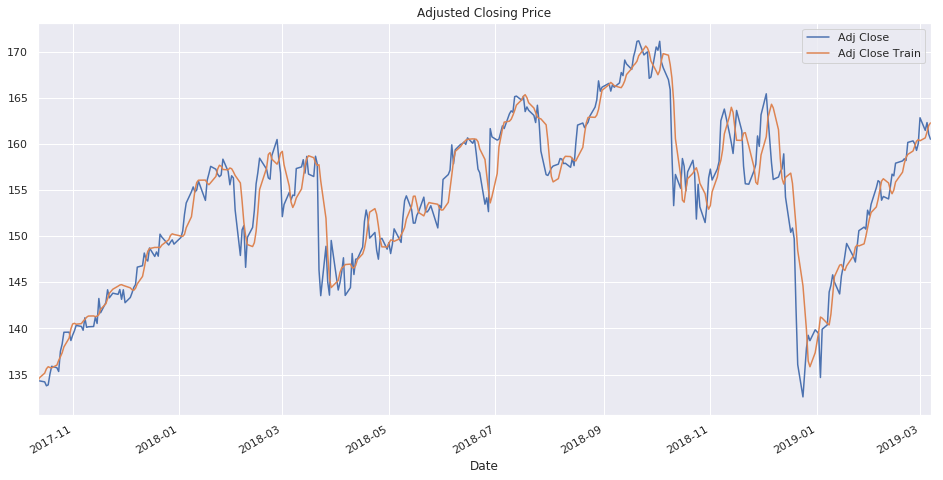

In [292]:
# Plot what it looks like for the training data
df_keras = df_yr.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 28 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)

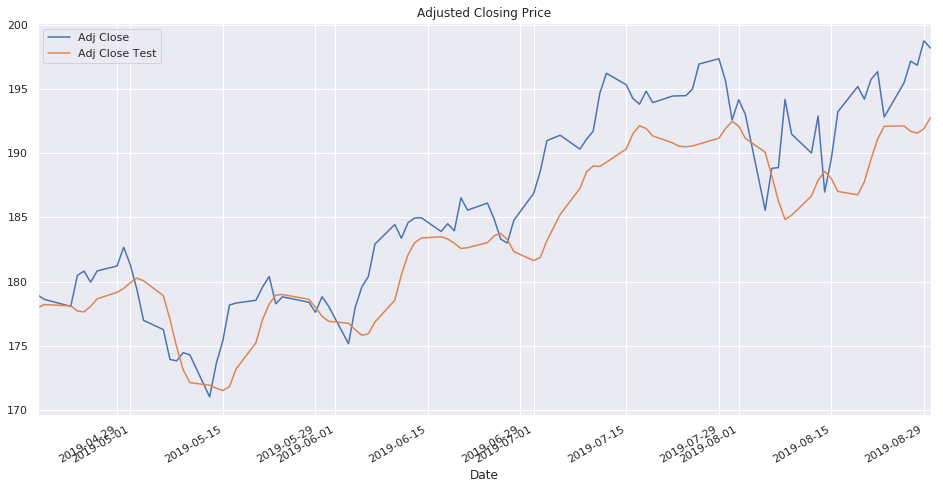

In [294]:
# Same for the test
df_keras = df_yr.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 28 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)


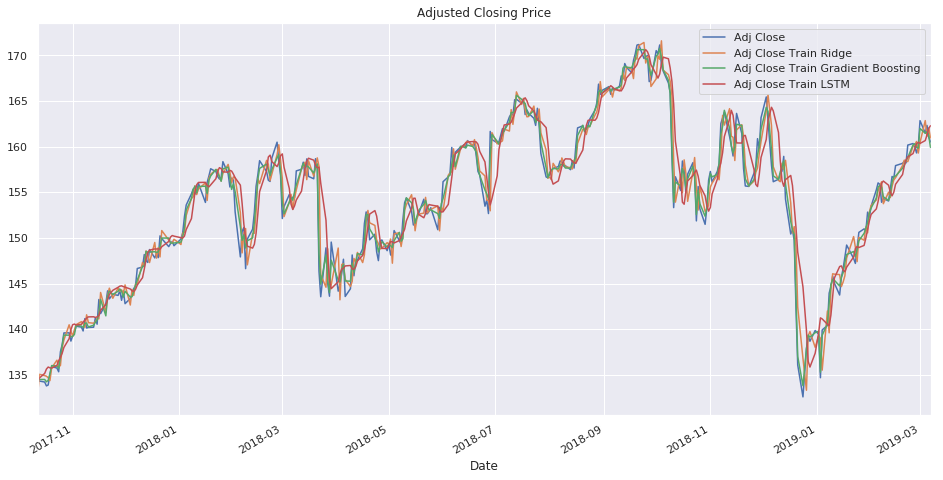

In [295]:
df_train = df_yr.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)

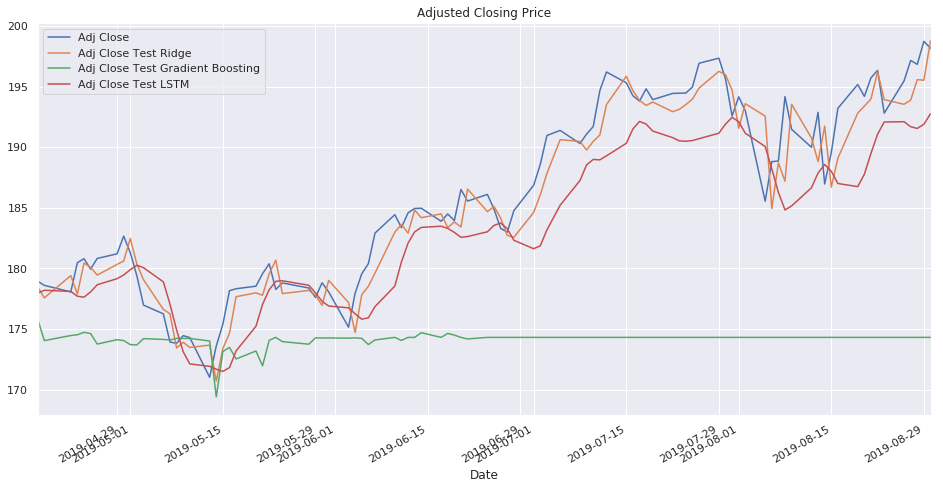

In [296]:
df_test = df_yr.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='ACN', figsize=(16,8), title='Adjusted Closing Price', grid=True)

In [0]:
num_days = 10 # Let's try and forecase the next 10 days or two years

# Get the last window_size (32) days
data_seed = df_yr['Adj Close'].values[-window_size:][None]
# Get the normalized data as well for the neural network
data_seed_norm = scaler.transform(data_seed)
input_values = {"ridge": data_seed, "gb": data_seed, "keras": data_seed_norm.copy()}
values = {"ridge": [], "gb": [], "keras": []}
for i in range(num_days): # For each day...
    # Predict the next price given the previous N prices
    values["ridge"].append(ridge_model.predict(input_values["ridge"])[0])
    values["gb"].append(gb_model.predict(input_values["gb"])[0])
    values["keras"].append(keras_model.predict(input_values["keras"][...,None])[0][0])

    # Dump the oldest price and put the newest price at the end
    for v in input_values:
        val = input_values[v]
        val = np.insert(val, -1, values[v][-1], axis=1)
        val = np.delete(val, 0, axis=1)
        input_values[v] = val.copy()

# Convert all to NumPy arrays
for v in input_values:
    values[v] = np.array(values[v])

# Unnormalize prices from NN approach
values["keras"] = scaler.inverse_transform(values["keras"][None])[0]

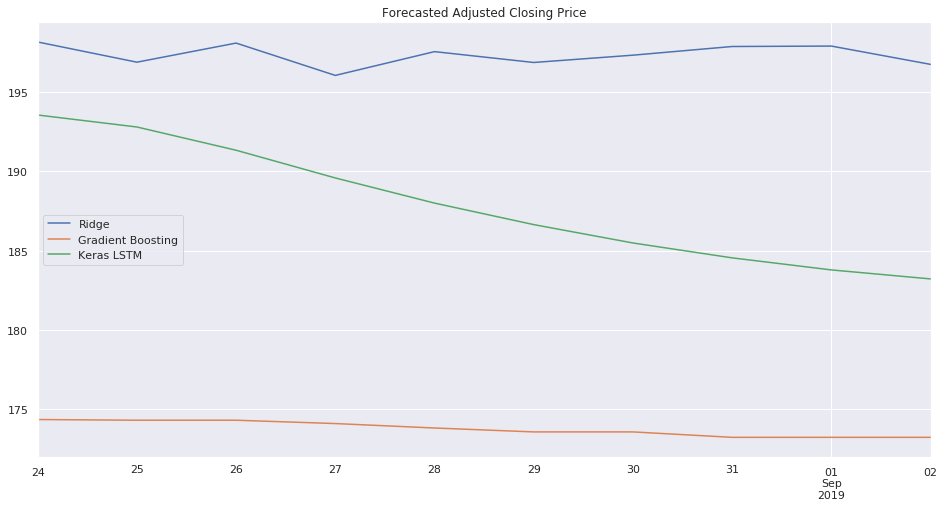

In [308]:
from datetime import timedelta, datetime
#last_date = datetime.strptime(df_yr.index[-1], '%Y-%m-%d')
last_date = datetime.strptime('2019-08-24', '%Y-%m-%d')
df_forecast = pd.DataFrame()
df_forecast["Ridge"] = values["ridge"]
df_forecast["Gradient Boosting"] = values["gb"]
df_forecast["Keras LSTM"] = values["keras"]
df_forecast.index = pd.date_range(start=last_date, periods=num_days)
df_forecast.plot(label='ACN', figsize=(16,8), title='Forecasted Adjusted Closing Price', grid=True)
